## Experiment 4 (section 6.4) 
Training MobileNetV1 on our mushroom dataset for multiclass classification

In [ ]:
import os
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import numpy as np
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from datetime import datetime
now = str(datetime.now())
%load_ext tensorboard
import zipfile

In [ ]:
os.mkdir('raw')

In [ ]:
zippath='../../datasets/dataset.zip'
with zipfile.ZipFile(zippath, 'r') as zip_ref:
    zip_ref.extractall('raw')

We are importing the MobileNetV1 model and utilising transfer learning, we are not including the top layer of the model and we are using the version of the model that is pre-trained on the ImageNet dataset.

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
pre_trained_model = MobileNet(input_shape = (224, 224, 3), 
                                include_top = False,
                                weights = 'imagenet')

17235968/17225924 [==============================] - 0s 0us/step


Now we are freezing all the layers, as per the transfer learning process.

In [ ]:
for layer in pre_trained_model.layers:
   layer.trainable = False

We add the classification header at the end of the model, that consists of the layers listed below

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.metrics import CategoricalAccuracy

x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)       
x = tf.keras.layers.Dense(24, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.00001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

We are splitting the data to three subsets: training, validation and test datasets.

The ratio we established to be the best is 60/20/20.

In [ ]:
!rm -rf tmp

In [ ]:
import os
from shutil import copyfile
from pathlib import Path
import re
import pandas as pd
from tqdm import tqdm

import random
def split_data(SOURCE, TRAINING, VALID, TESTING, splitsizetrain, splitsizevalid, splitsizetest):
    files = []

    os.mkdir(TRAINING)
    os.mkdir(VALID)
    os.mkdir(TESTING)


    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * splitsizetrain)
    valid_length = int(len(files) * 0.8)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[:training_length]
    testing_set = shuffled_set[training_length:valid_length]
    valid_set = shuffled_set[valid_length:]


    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALID + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)    

p = Path('./raw')
print(p)
folders = [x for x in p.iterdir() if x.is_dir()]
split_size_train = .6
split_size_valid = .2
split_size_test = .2

try:
  os.mkdir('tmp')
except:
  print('error')

try:  
  os.mkdir('tmp/train')
  os.mkdir('tmp/valid')
  os.mkdir('tmp/test')
except:
  print('error but here')  

for f in tqdm(folders):
    z = Path(f)
    source = './'+str(z)+'/'

    split_data(source, './tmp/train/'+z.parts[1]+'/', './tmp/valid/'+z.parts[1]+'/',
                './tmp/test/'+z.parts[1]+'/',split_size_train, split_size_valid, split_size_test)
    



raw


100%|██████████| 24/24 [00:02<00:00,  8.77it/s]


Just plain loading the dataset from the folders.

We augument the training portion of the dataset with a couple of operations, so we have a slightly bigger dataset.

Important operation is to set the Testing dataset to not be shuffled, for we are using it later to make classification reports.

We are using a batchsize of 20 because there is very little number of images in all of our classes, so the model can glance over it properly.

In [ ]:
BATCHSIZE = 20
TRAINING_DIR = "./tmp/train/"
train_datagen = ImageDataGenerator(rescale=1/127.5-1,  #mobilenet requires -1;1 range
                                   rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=BATCHSIZE,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

VALIDATION_DIR = "./tmp/valid/"
validation_datagen = ImageDataGenerator(rescale=1/127.5-1)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=BATCHSIZE,
                                                              class_mode='categorical',
                                                              target_size=(224, 224))

TESTING_DIR = "./tmp/test/"
test_datagen = ImageDataGenerator(rescale=1/127.5-1)
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                              batch_size=BATCHSIZE,
                                                              shuffle=False,
                                                              class_mode='categorical',
                                                              target_size=(224, 224))
7247
print(len(train_generator.classes))
print(len(validation_generator.classes))
print(len(test_generator.classes))

Found 4337 images belonging to 24 classes.
Found 1462 images belonging to 24 classes.
Found 1448 images belonging to 24 classes.
4337
1462
1448


In [ ]:
labels = list(dict.keys(train_generator.class_indices))
(labels)

['Agaricus_arvensis',
 'Amanita_muscaria',
 'Amanita_pantherina',
 'Amanita_phalloides',
 'Auricularia_auricula-judae',
 'Boletus_reticulatus_edulis',
 'Calocera_viscosa',
 'Cantharellus_cibarius',
 'Chlorociboria_aeruginascens',
 'Cortinarius_semisanguineus',
 'Cortinarius_violaceus',
 'Galerina_marginata',
 'Gyromitra_esculenta',
 'Hygrocybe_cantharellus',
 'Lactarius_deliciosus',
 'Leccinum_scabrum',
 'Lepista_nuda',
 'Macrolepiota_procera',
 'Pleurotus_ostreatus',
 'Rubroboletus_satanas',
 'Russula_cyanoxantha',
 'Russula_lepida',
 'Sarcoscypha_austriaca',
 'Suillus_luteus']

We are defining some operations that help us during training process, such as automatic stopping of training, automatic LR decreasing, model saving and Tensorboard, that comes with accuracy/loss scalars logs, and we also log the confusion matrix after each epoch into Tensorboard.

In [ ]:
!rm -rf ./logs/ 

In [ ]:
import itertools 
import seaborn as sb
def plot_confusion_matrix(cm, class_names): 
    plt.figure(figsize=(12, 10), dpi=200, facecolor="white")
    
    ax = plt.subplot()
    sb.heatmap(cm, ax=ax, cmap='plasma')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(labels, rotation = 45, ha="right")
    ax.set_yticklabels(labels,rotation=0)
    plt.tight_layout()
    result = ax.get_figure()
    return result

from io import BytesIO
def plot_to_image(figure):   
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)  
    image = tf.expand_dims(image, 0)    
    return image    

from sklearn import metrics

def log_confusion_matrix(epoch, logs):
    predictions = model.predict(validation_generator)
    predictions = np.argmax(predictions, axis=1)

    cm = metrics.confusion_matrix(validation_generator.classes, predictions)
    figure = plot_confusion_matrix(cm, labels)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)   


from datetime import datetime

logsdir = 'logs/scalars_' + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer_cm = tf.summary.create_file_writer(logsdir)
from keras.callbacks import ModelCheckpoint, TensorBoard, LambdaCallback, EarlyStopping, ReduceLROnPlateau

callbacks = [
              TensorBoard(log_dir=logsdir),
              LambdaCallback(on_epoch_end=log_confusion_matrix),
              ModelCheckpoint('best_model_frozen_'+now+'.hdf5', monitor='val_accuracy', verbose=1, mode='auto', period=1),
]

We dont the EarlyStopping and ReduceLRonPlateau during the training with frozen layers.

In [ ]:
%tensorboard --logdir {logsdir}

As our dataset is not well balanced, we need to find out the balance of weights between them.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
cw = dict(zip( np.unique(train_generator.classes), weights))
print(cw)

{0: 1.1734307359307359, 1: 0.9874772313296903, 2: 1.0952020202020203, 3: 0.9267094017094017, 4: 1.0629901960784314, 5: 0.9663547237076648, 6: 0.9411892361111112, 7: 0.9715501792114696, 8: 0.9929029304029304, 9: 1.0692800788954635, 10: 0.9561287477954145, 11: 0.9983885819521179, 12: 0.9663547237076648, 13: 0.9267094017094017, 14: 1.0506298449612403, 15: 0.9874772313296903, 16: 0.9510964912280702, 17: 0.9983885819521179, 18: 1.2816193853427895, 19: 1.1154835390946503, 20: 0.8444314641744548, 21: 1.1154835390946503, 22: 0.8687900641025641, 23: 0.9561287477954145}


We may begin the frozen training process now.

In [ ]:
FROZEN_END = 12
history = model.fit(train_generator, epochs=FROZEN_END,
                    validation_data=validation_generator,
                    class_weight=cw,
                    callbacks=[callbacks]
                    )

Epoch 1/12
217/217 [==============================] - ETA: 0s - loss: 3.3941 - accuracy: 0.1100
Epoch 00001: saving model to drive/MyDrive/bp/final_files/exp4_mobilenet/best_model_frozen.hdf5
217/217 [==============================] - 113s 475ms/step - loss: 3.3941 - accuracy: 0.1100 - val_loss: 2.7644 - val_accuracy: 0.1949
Epoch 2/12
217/217 [==============================] - ETA: 0s - loss: 2.8399 - accuracy: 0.1858
Epoch 00002: saving model to drive/MyDrive/bp/final_files/exp4_mobilenet/best_model_frozen.hdf5
217/217 [==============================] - 103s 475ms/step - loss: 2.8399 - accuracy: 0.1858 - val_loss: 2.5341 - val_accuracy: 0.2674
Epoch 3/12
217/217 [==============================] - ETA: 0s - loss: 2.6446 - accuracy: 0.2350
Epoch 00003: saving model to drive/MyDrive/bp/final_files/exp4_mobilenet/best_model_frozen.hdf5
217/217 [==============================] - 103s 473ms/step - loss: 2.6446 - accuracy: 0.2350 - val_loss: 2.4177 - val_accuracy: 0.3051
Epoch 4/12
217/217 

In [ ]:
tf.keras.models.save_model(
    model,
    'multi_frozen_'+now+'.hdf5'
)

In [ ]:
import pickle

with open('history_frozen_'+now+'.bytes', 'wb') as f:
        pickle.dump(history.history, f)

In [ ]:
for layer in model.layers:
   layer.trainable = True

# we now introduce SGD as an optimizer with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
def log_confusion_matrix_tuning(epoch, logs):
    predictions = model.predict(validation_generator)
    predictions = np.argmax(predictions, axis=1)

    cm = metrics.confusion_matrix(validation_generator.classes, predictions)
    figure = plot_confusion_matrix(cm, labels)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm_tuning.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)   


logsdir_tuning = 'logs/scalars_' + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer_cm_tuning = tf.summary.create_file_writer(logsdir_tuning)


callbacks_tuning = [
              TensorBoard(log_dir=logsdir_tuning),
              LambdaCallback(on_epoch_end=log_confusion_matrix_tuning),
              ModelCheckpoint('drive/MyDrive/bp/final_files/exp4_dense121_DEMO/best_model_frozen.hdf5', monitor='val_accuracy', verbose=1, mode='auto', period=1),
              EarlyStopping(monitor='val_accuracy', patience=8, verbose=1),
              ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=2, verbose=1)
]

In [ ]:
%tensorboard --logdir {logsdir_tuning}

In [ ]:
epochsnum = 50

historyTuned = model.fit(train_generator, epochs=epochsnum,
                    validation_data=validation_generator, callbacks=[callbacks_tuning])

Epoch 1/50
217/217 [==============================] - ETA: 0s - loss: 3.1220 - accuracy: 0.3622
Epoch 00001: saving model to drive/MyDrive/bp/final_files/exp4_mobilenet/best_model_tuned.hdf5
217/217 [==============================] - 115s 511ms/step - loss: 3.1220 - accuracy: 0.3622 - val_loss: 1.2760 - val_accuracy: 0.6245 - lr: 1.0000e-04
Epoch 2/50
217/217 [==============================] - ETA: 0s - loss: 1.4431 - accuracy: 0.5780
Epoch 00002: saving model to drive/MyDrive/bp/final_files/exp4_mobilenet/best_model_tuned.hdf5
217/217 [==============================] - 112s 516ms/step - loss: 1.4431 - accuracy: 0.5780 - val_loss: 1.0003 - val_accuracy: 0.6929 - lr: 1.0000e-04
Epoch 3/50
217/217 [==============================] - ETA: 0s - loss: 1.1460 - accuracy: 0.6532
Epoch 00003: saving model to drive/MyDrive/bp/final_files/exp4_mobilenet/best_model_tuned.hdf5
217/217 [==============================] - 111s 512ms/step - loss: 1.1460 - accuracy: 0.6532 - val_loss: 0.8615 - val_accur

In [ ]:
import pickle
with open('history_tuned_'+now+'.bytes', 'wb') as f:
        pickle.dump(historyTuned.history, f)

In [ ]:
tf.keras.models.save_model(
    model,
    'multi_tuned_'+now+'.hdf5'
)

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)

['Agaricus_arvensis', 'Amanita_muscaria', 'Amanita_pantherina', 'Amanita_phalloides', 'Auricularia_auricula-judae', 'Boletus_reticulatus_edulis', 'Calocera_viscosa', 'Cantharellus_cibarius', 'Chlorociboria_aeruginascens', 'Cortinarius_semisanguineus', 'Cortinarius_violaceus', 'Galerina_marginata', 'Gyromitra_esculenta', 'Hygrocybe_cantharellus', 'Lactarius_deliciosus', 'Leccinum_scabrum', 'Lepista_nuda', 'Macrolepiota_procera', 'Pleurotus_ostreatus', 'Rubroboletus_satanas', 'Russula_cyanoxantha', 'Russula_lepida', 'Sarcoscypha_austriaca', 'Suillus_luteus']
1448
1448
                             precision    recall  f1-score   support

          Agaricus_arvensis       0.67      0.76      0.72        51
           Amanita_muscaria       0.93      0.93      0.93        61
         Amanita_pantherina       0.86      0.87      0.86        55
         Amanita_phalloides       0.85      0.85      0.85        65
 Auricularia_auricula-judae       0.82      0.79      0.80        57
 Boletus_ret

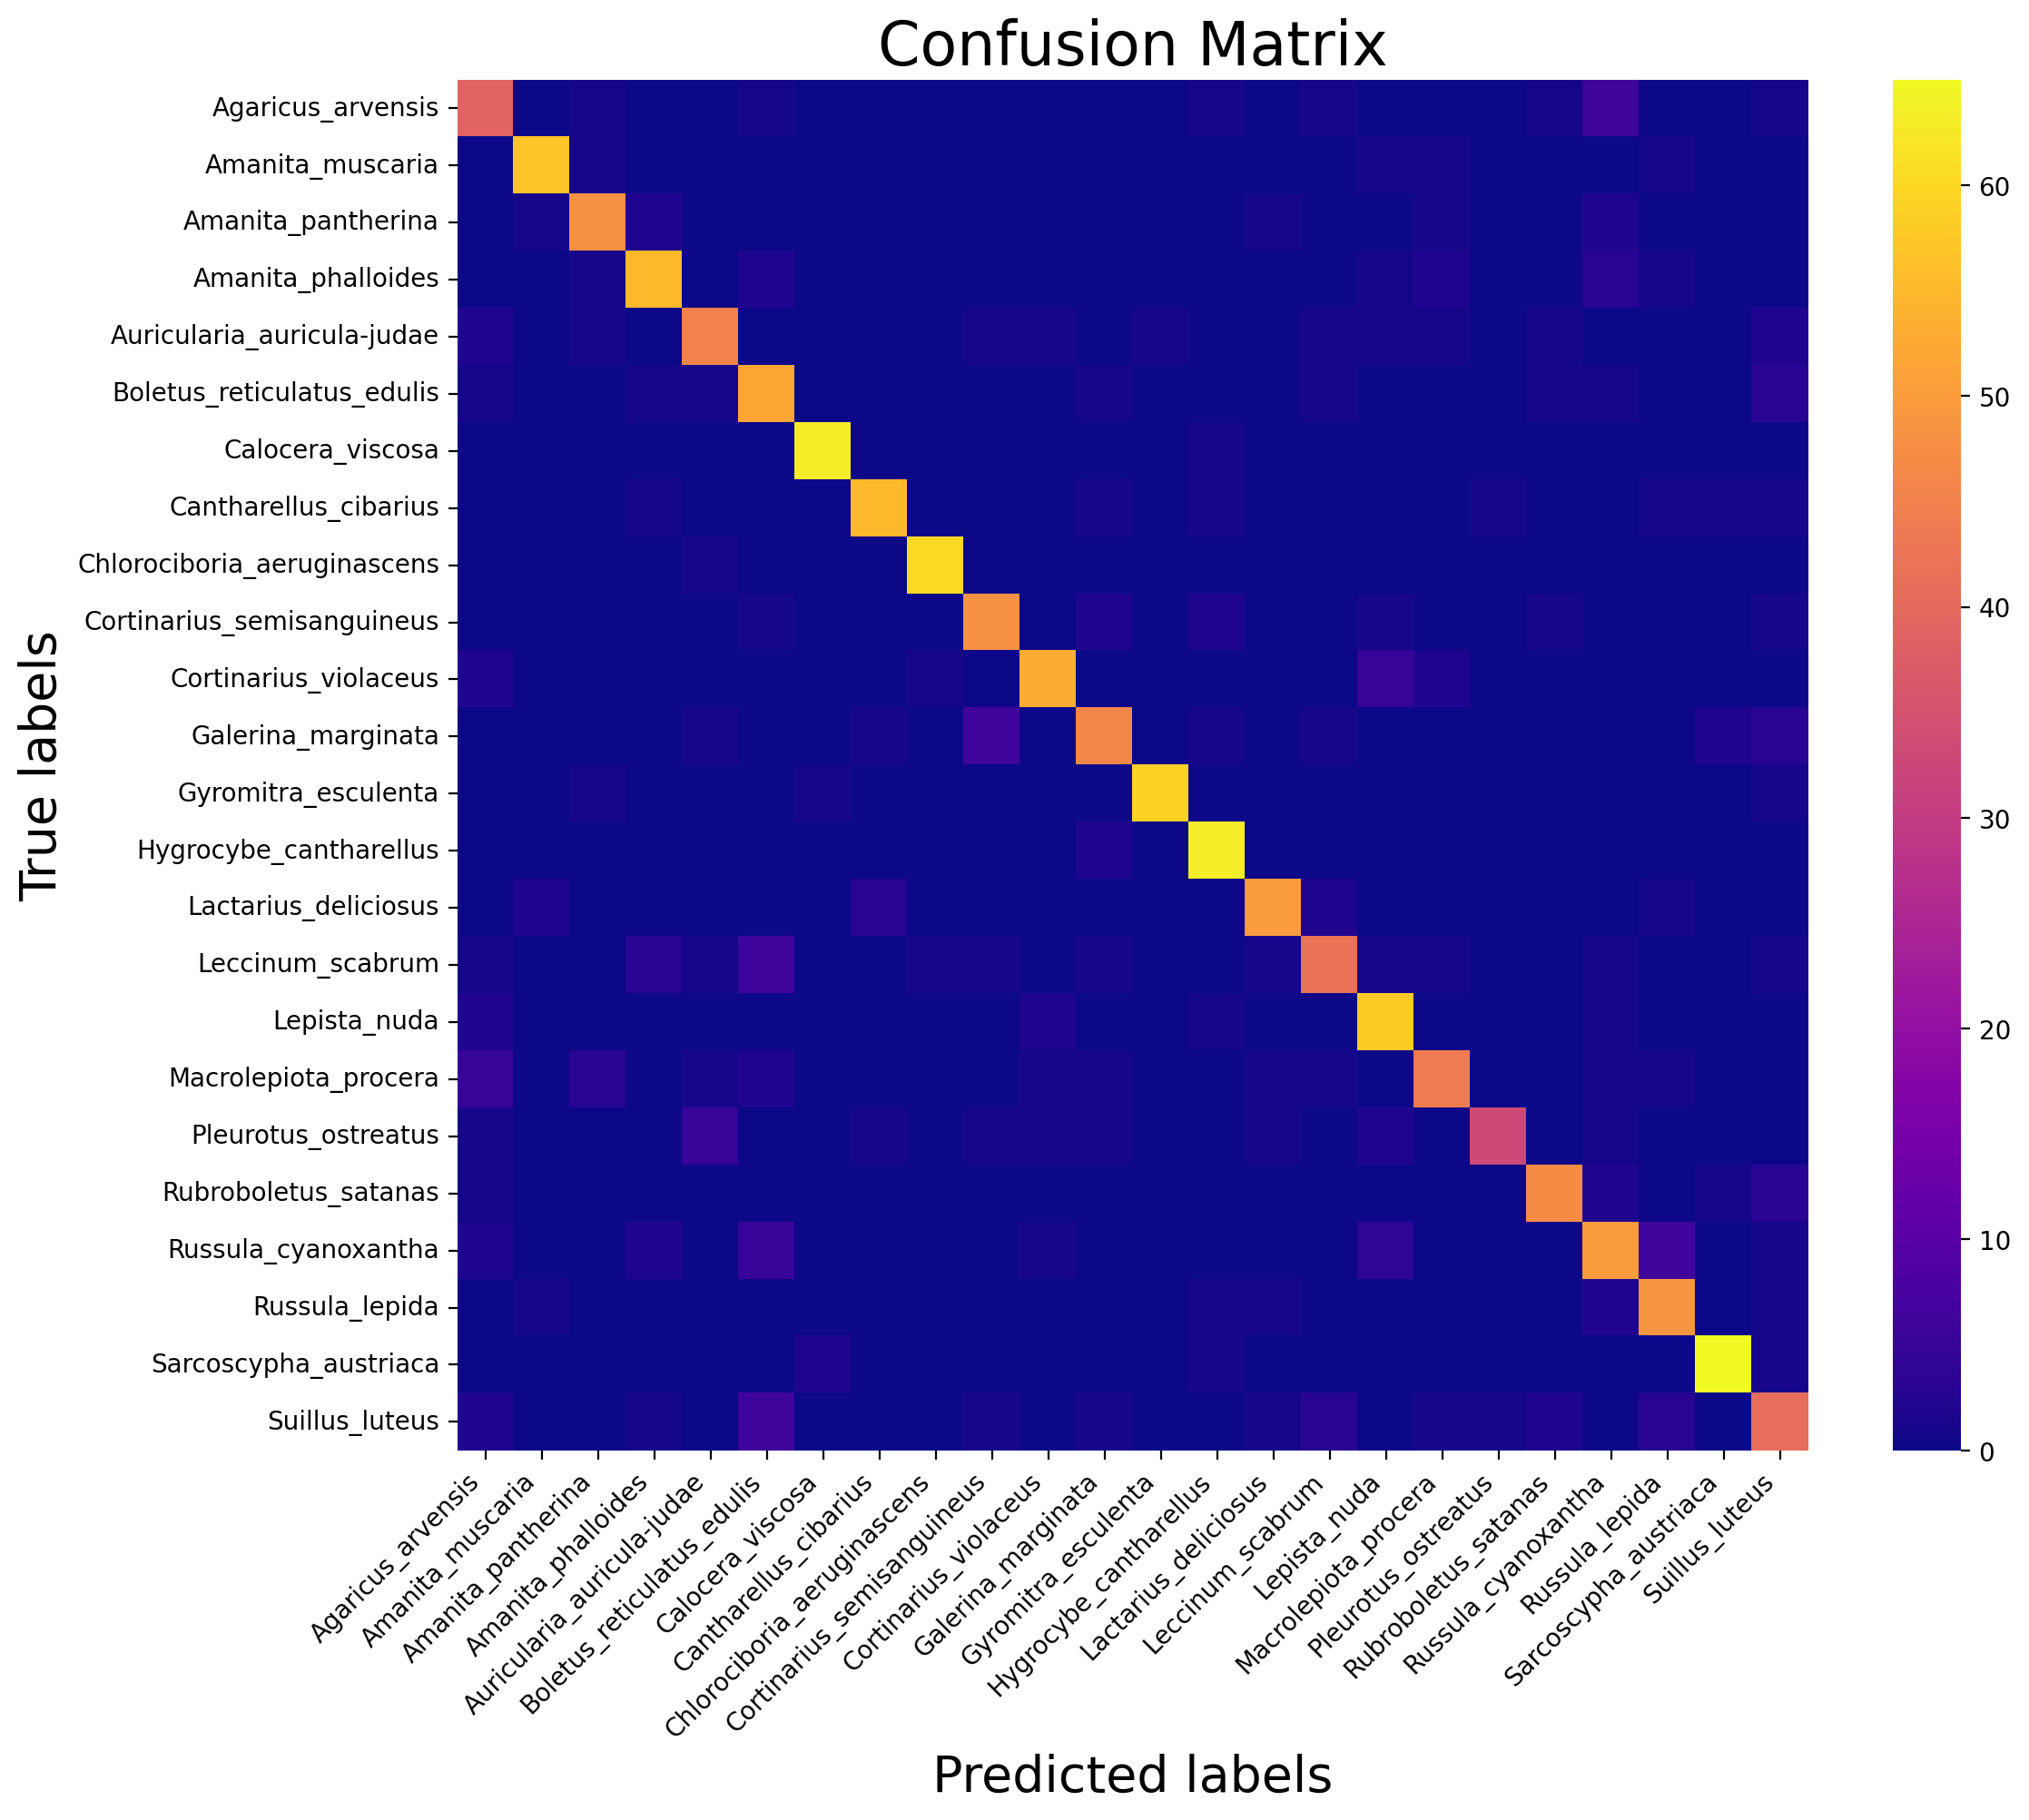

In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sb
plt.figure(figsize=(12, 10), dpi=200, facecolor="white")
cm1 = metrics.confusion_matrix(test_generator.classes, predictions)
ax = plt.subplot()

result = sb.heatmap(cm1, ax=ax, cmap='plasma').get_figure()

ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=24)
ax.set_xticklabels(labels, rotation = 45, ha="right")
ax.set_yticklabels(labels,rotation=0)

result.savefig('drive/MyDrive/bp/final_files/exp4_mobilenet/savedCM_'+now+'.png')


print(labels)

print(len(test_generator.classes))
print(len(predictions))

print(metrics.classification_report(test_generator.classes, predictions, target_names=labels))
print(matthews_corrcoef(test_generator.classes, predictions))

In [ ]:
cr = metrics.classification_report(test_generator.classes, predictions, target_names=labels, output_dict=True)

In [ ]:
import pandas as pd
df = pd.DataFrame(cr).transpose()

In [ ]:
df = df.drop(['accuracy','macro avg', 'weighted avg'])


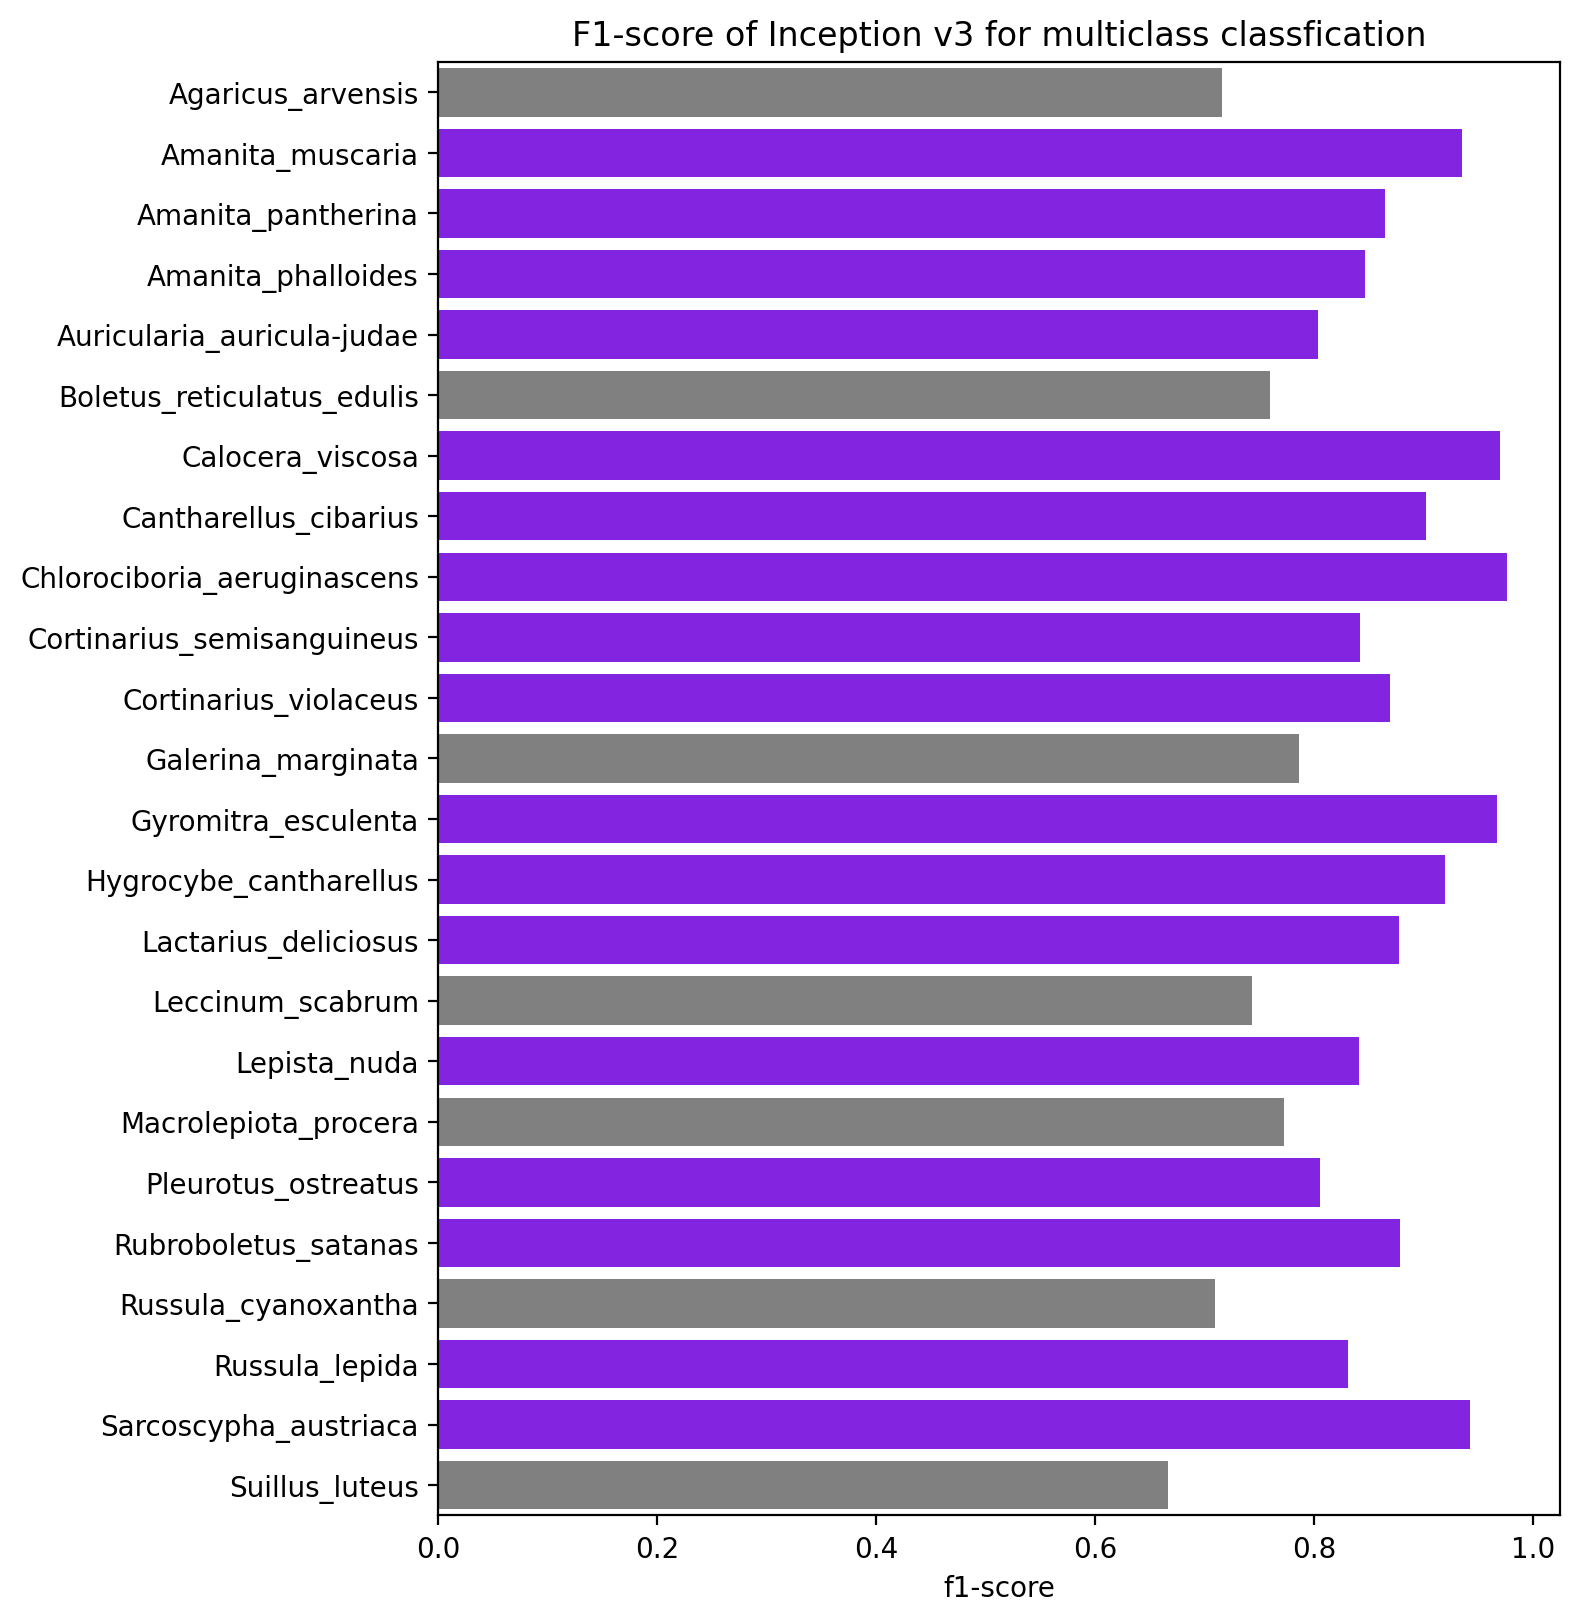

In [ ]:
import seaborn as sb
from matplotlib import rcParams

clrs = ['grey' if (x < 0.8) else '#8305FF' for x in df['f1-score'] ]
plt.figure(figsize=(8, 8), dpi=200, facecolor="white")

g = sb.barplot(y= df.index, x='f1-score', data = df,palette=clrs)
plt.tight_layout()
g.set_title("F1-score of Inception v3 for multiclass classfication")

g.figure.savefig('drive/MyDrive/bp/final_files/exp4_mobilenet/classesRanking_'+now+'.png', format='png', dpi=200)

In [ ]:
model.evaluate(train_generator)

217/217 [==============================] - 82s 377ms/step - loss: 0.2154 - accuracy: 0.9345


[0.2153950184583664, 0.934516966342926]

In [ ]:
model.evaluate(validation_generator)

74/74 [==============================] - 13s 178ms/step - loss: 0.4811 - accuracy: 0.8577


[0.48113682866096497, 0.8577291369438171]

In [ ]:
model.evaluate(test_generator)

73/73 [==============================] - 13s 178ms/step - loss: 0.5438 - accuracy: 0.8439


[0.543816864490509, 0.8439226746559143]

In [ ]:
import pandas as pd

f = pd.DataFrame(pd.read_pickle('history_frozen_'+now+'.bytes'))
t = pd.DataFrame(pd.read_pickle('history_tuned_'+now+'.bytes'))

concatenated = pd.concat([f,t], ignore_index=True)
concatenated = concatenated.drop('lr', 1)

In [ ]:
acc=concatenated['accuracy']
val_acc=concatenated['val_accuracy']
loss=concatenated['loss']
val_loss=concatenated['val_loss']
epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.axvline(x=12, label='Start of fine-tuning', c='g')
plt.legend()

plt.savefig('with_line_savedacc_'+now+'.png', dpi=200)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.axvline(x=FROZEN_END, label='Start of fine-tuning', c='g')
plt.legend()
plt.savefig('with_line_savedloss_'+now+'.png', dpi=200)
plt.figure()